In this notebook, we will analyze a NuSTAR data of the black hole X-ray binary H1743-322 with Stingray. Here we assume that the user has already reduced the data with the official pipeline and ran `barycorr` or other tools to refer the event times to the solar system barycenter.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from stingray.powerspectrum import AveragedPowerspectrum, DynamicalPowerspectrum
from stingray.crossspectrum import AveragedCrossspectrum
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray.gti import create_gti_from_condition

## Quicklook NuSTAR data with Stingray

Let us load the data from two event lists corresponding to the two detectors onboard NuSTAR. `fmt='hea'` indicates event data produced by HEAsoft tools or compatible (e.g. XMM-Newton).

In [2]:
evA = EventList.read('nustar_A_src.evt', 'hea')
evB = EventList.read('nustar_B_src.evt', 'hea')


For the sake of a quicklook, let us join the two event lists

In [3]:
all_ev = evA.join(evB)


Let us calculate the light curve and plot it. 

In red, we show the bad time intervals, when the satellite was not acquiring valid data due to Earth occultation, SAA passages, or other issues.

In [4]:
lc = all_ev.to_lc(100)


(5000.0, 6500.0)

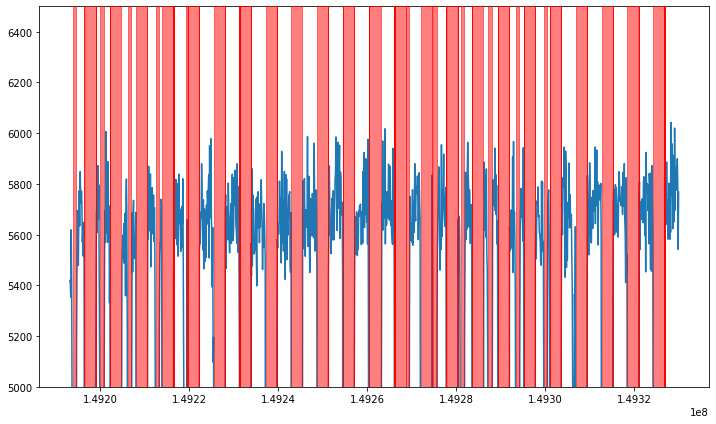

In [5]:
plt.figure(figsize=(12, 7))
plt.plot(lc.time, lc.counts)
bad_time_intervals = list(zip(lc.gti[:-1, 1], lc.gti[1:, 0]))
for b in bad_time_intervals:
    plt.axvspan(b[0], b[1], color='r', alpha=0.5, zorder=10)

plt.ylim([5000, 6500])

The light curve shows some long-term variability. Let us look at the colors. First of all, let us check that the events contain the energy of each photon. This should be the case, because NuSTAR data, together with XMM and NICER, are very well understood by Stingray and the calibration is done straight away.

In [6]:
all_ev.energy

array([ 6.24     ,  3.4      , 14.4800005, ...,  9.64     ,  8.76     ,
        4.2      ], dtype=float32)

Other missions might have all_ev.energy set to None. In which case, one needs to use all_ev.pi and express the energy through the PI channels (See the HENDRICS documentation for more advanced calibration using the rmf files).

Also, we notice that some GTIs do not catch all bad intervals (see how the light curve drops close to GTI borders). We make a more aggressive GTI filtering now:

In [7]:
new_gti = create_gti_from_condition(lc.time, lc.counts > 5200)
all_ev.gti = new_gti
evA.gti = new_gti
evB.gti = new_gti
lc.gti = new_gti

Text(0, 0.5, 'Counts')

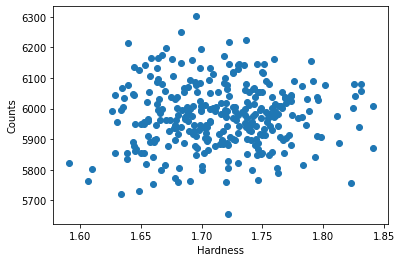

In [8]:
hard = (all_ev.energy > 10) & (all_ev.energy < 79)
soft = (all_ev.energy > 3) & (all_ev.energy < 5)

hard_ev = all_ev.apply_mask(hard)
soft_ev = all_ev.apply_mask(soft)

hard_lc = hard_ev.to_lc(200)
soft_lc = soft_ev.to_lc(200)

hard_lc.apply_gtis()
soft_lc.apply_gtis()

hardness_ratio = hard_lc.counts / soft_lc.counts
intensity = hard_lc.counts + soft_lc.counts

plt.figure()
plt.scatter(hardness_ratio, intensity)
plt.xlabel("Hardness")
plt.ylabel("Counts")

Despite some light curve variability, the hardness ratio seems pretty stable during the observation.

Let us now look at the power density spectrum. Notice that we are using a sampling time of 0.001 s, meaning that we will investigate the power spectrum up to 500 Hz

In [9]:
pds = AveragedPowerspectrum.from_events(all_ev, segment_size=256, dt=0.001, norm='leahy')

238it [00:01, 177.96it/s]


Text(0, 0.5, 'Power (Leahy)')

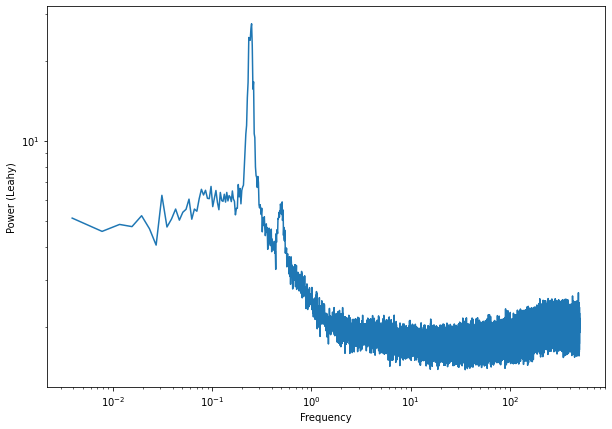

In [10]:
plt.figure(figsize=(10,7))
plt.loglog(pds.freq, pds.power)
plt.xlabel("Frequency")
plt.ylabel("Power (Leahy)")

Nice Quasi-periodic oscillations there! Note that at high frequencies the white noise level increases. This is not real variability, but an effect of **dead time**. The easiest way to get a flat periodogram at high frequencies is using the **cospectrum** instead of the power density spectrum. For this, we use separately the events from the two detectors. The cospectrum calculation is slightly slower than the power spectrum.

For an accurate way to correct the power density spectrum from dead time, see the documentation of `stingray.deadtime` and the Frequency Amplitude Difference (FAD) correction.

In [11]:
cs = AveragedCrossspectrum.from_events(evA, evB, segment_size=256, dt=0.001, norm='leahy')

238it [00:03, 78.00it/s]


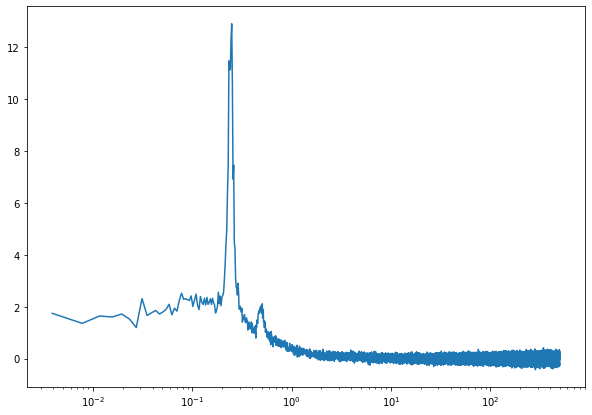

In [12]:
plt.figure(figsize=(10,7))
plt.semilogx(cs.freq, cs.power.real)

To improve the plot, we can rebin the data logarithmically

In [13]:
cs_reb = cs.rebin_log(0.02)

Text(0, 0.5, 'Cospectrum Power')

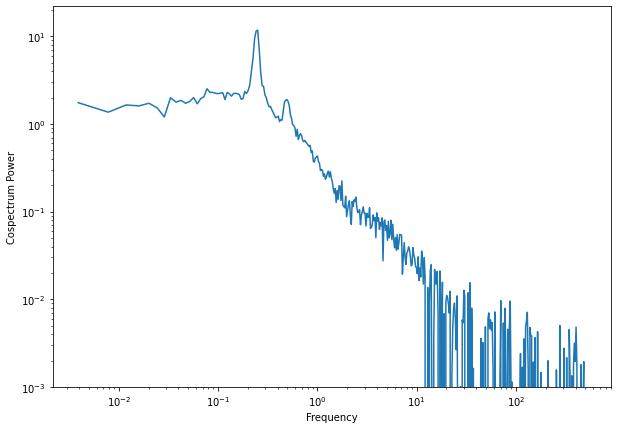

In [14]:
plt.figure(figsize=(10,7))
plt.loglog(cs_reb.freq, cs_reb.power.real)
plt.ylim([1e-3, None])
plt.xlabel("Frequency")
plt.ylabel("Cospectrum Power")

For deeper analysis (e.g. time lags and other products), please refer to the relevant notebooks